# Full Experiment with CatBoost Models

This notebook runs a complete experiment using all available features with both CatBoostClassifier and CatBoostRanker models.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import time

from lavka_recsys import Config, Experiment, setup_logging

In [2]:
setup_logging()

<Logger lavka_recsys (DEBUG)>

## Baseline Experiments

First, let's see how well a model that outputs random predictions does.

In [ ]:
# Create experiment
config = (Config
    .load('default_config.yaml')
    .set('feature_generators', ['random_noise'])
    .set('model.type', 'random_baseline')
)
random_experiment = Experiment("random_baseline", config)

# Setup and run
start_time = time.time()
random_experiment.setup()
random_results = random_experiment.run()
random_time = time.time() - start_time

# Print metrics
print(f"\nRandom Baseline Results (completed in {random_time:.2f} seconds):")
for metric, value in random_results['metrics'].items():
    print(f"  {metric}: {value:.6f}")

2025-05-05 17:04:52,189 - lavka_recsys.Experiment(random_baseline_587898) - INFO - Initialized experiment: random_baseline_587898
2025-05-05 17:04:52,198 - lavka_recsys.Experiment(random_baseline_587898) - INFO - Config saved: results/random_baseline_587898_config.json
2025-05-05 17:04:52,199 - lavka_recsys.Experiment(random_baseline_587898) - INFO - Setting up experiment environment...
2025-05-05 17:04:52,201 - lavka_recsys.DataLoader - INFO - Loading training data from ../../data/lavka/train.parquet


2025-05-05 17:04:52,508 - lavka_recsys.DataLoader - INFO - Loading test data from ../../data/lavka/test.parquet
2025-05-05 17:04:52,924 - lavka_recsys.DataLoader - INFO - Holdout Split:
2025-05-05 17:04:52,951 - lavka_recsys.DataLoader - INFO -   train: 2022-12-31 18:46:42 → 2024-01-03 17:31:52 (15_070_276 rows, 367 days)
2025-05-05 17:04:52,955 - lavka_recsys.DataLoader - INFO -   holdout: 2024-01-03 17:56:48 → 2024-02-02 17:34:51 (1_438_338 rows, 29 days)
2025-05-05 17:04:52,956 - lavka_recsys.Experiment(random_baseline_587898) - INFO - Setup complete.
2025-05-05 17:04:52,957 - lavka_recsys.Experiment(random_baseline_587898) - INFO - Starting experiment run...
2025-05-05 17:04:53,437 - lavka_recsys.DataLoader - INFO - Validation Split:
2025-05-05 17:04:53,459 - lavka_recsys.DataLoader - INFO -   train_history: 2022-12-31 18:46:42 → 2023-11-04 17:16:23 (12_082_523 rows, 307 days)
2025-05-05 17:04:53,463 - lavka_recsys.DataLoader - INFO -   train_target: 2023-11-04 18:19:12 → 2023-12-0

In [4]:
# random_experiment.create_submission()

Kaggle Public Score = `0.30071`.

Now let's consider a baseline that only considers popularity (i.e. `product_total_purchases`).

In [ ]:
# Create experiment
config = (Config
    .load('default_config.yaml')
    .set('feature_generators', ['product_stats'])
    .set('model.type', 'single_feature')
    .set('model.config.single_feature.feature_name', 'product_total_purchases')
    .set('model.config.single_feature.desc', True)
)
pop_experiment = Experiment(
    "popularity_baseline",
    config
)

# Setup and run
start_time = time.time()
pop_experiment.setup()
pop_results = pop_experiment.run()
pop_time = time.time() - start_time

# Print metrics
print(f"\nPopularity Baseline Results (completed in {pop_time:.2f} seconds):")
for metric, value in pop_results['metrics'].items():
    print(f"  {metric}: {value:.6f}")

2025-05-05 17:05:05,667 - lavka_recsys.Experiment(popularity_baseline_03697e) - INFO - Initialized experiment: popularity_baseline_03697e
2025-05-05 17:05:05,674 - lavka_recsys.Experiment(popularity_baseline_03697e) - INFO - Config saved: results/popularity_baseline_03697e_config.json
2025-05-05 17:05:05,675 - lavka_recsys.Experiment(popularity_baseline_03697e) - INFO - Setting up experiment environment...
2025-05-05 17:05:05,677 - lavka_recsys.DataLoader - INFO - Loading training data from ../../data/lavka/train.parquet


2025-05-05 17:05:06,006 - lavka_recsys.DataLoader - INFO - Loading test data from ../../data/lavka/test.parquet
2025-05-05 17:05:06,297 - lavka_recsys.DataLoader - INFO - Holdout Split:
2025-05-05 17:05:06,324 - lavka_recsys.DataLoader - INFO -   train: 2022-12-31 18:46:42 → 2024-01-03 17:31:52 (15_070_276 rows, 367 days)
2025-05-05 17:05:06,328 - lavka_recsys.DataLoader - INFO -   holdout: 2024-01-03 17:56:48 → 2024-02-02 17:34:51 (1_438_338 rows, 29 days)
2025-05-05 17:05:06,329 - lavka_recsys.Experiment(popularity_baseline_03697e) - INFO - Setup complete.
2025-05-05 17:05:06,330 - lavka_recsys.Experiment(popularity_baseline_03697e) - INFO - Starting experiment run...
2025-05-05 17:05:06,725 - lavka_recsys.DataLoader - INFO - Validation Split:
2025-05-05 17:05:06,745 - lavka_recsys.DataLoader - INFO -   train_history: 2022-12-31 18:46:42 → 2023-11-04 17:16:23 (12_082_523 rows, 307 days)
2025-05-05 17:05:06,749 - lavka_recsys.DataLoader - INFO -   train_target: 2023-11-04 18:19:12 → 2

In [7]:
# pop_experiment.create_submission()

Kaggle Public Score = `0.33188`.

## CatBoost Classifier Experiment

Run an experiment with CatBoost Classifier.

In [6]:
classifier_experiment = Experiment("catboost_classifier", (Config
    .load('default_config.yaml')
    .set('model.type', 'catboost_classifier')
    .set('target', 'CartUpdate_vs_View')
))

# Setup and run
classifier_experiment.setup()
classifier_results = classifier_experiment.run()

# Print metrics
print(f"\nCatBoost Classifier Results:")
for metric, value in classifier_results['metrics'].items():
    print(f"  {metric}: {value:.6f}")

# Print feature importance
if 'feature_importance' in classifier_results:
    print("\nTop 10 Important Features:")
    top_features = sorted(classifier_results['feature_importance'].items(), 
                        key=lambda x: x[1], reverse=True)[:10]
    for feature, importance in top_features:
        print(f"  {feature}: {importance:.6f}")

2025-05-06 00:23:01,636 - lavka_recsys.Experiment(catboost_classifier_2ab624) - INFO - Initialized experiment: catboost_classifier_2ab624
2025-05-06 00:23:01,646 - lavka_recsys.Experiment(catboost_classifier_2ab624) - INFO - Config saved: results/catboost_classifier_2ab624_config.json
2025-05-06 00:23:01,648 - lavka_recsys.Experiment(catboost_classifier_2ab624) - INFO - Setting up experiment environment...
2025-05-06 00:23:01,649 - lavka_recsys.DataLoader - INFO - Loading training data from ../../data/lavka/train.parquet


2025-05-06 00:23:01,817 - lavka_recsys.DataLoader - INFO - Loading test data from ../../data/lavka/test.parquet
2025-05-06 00:23:02,129 - lavka_recsys.DataLoader - INFO - Holdout Split:
2025-05-06 00:23:02,158 - lavka_recsys.DataLoader - INFO -   train: 2022-12-31 18:46:42 → 2024-01-03 17:31:52 (15_070_276 rows, 367 days)
2025-05-06 00:23:02,162 - lavka_recsys.DataLoader - INFO -   holdout: 2024-01-03 17:56:48 → 2024-02-02 17:34:51 (1_438_338 rows, 29 days)
2025-05-06 00:23:02,164 - lavka_recsys.Experiment(catboost_classifier_2ab624) - INFO - Setup complete.
2025-05-06 00:23:02,165 - lavka_recsys.Experiment(catboost_classifier_2ab624) - INFO - Starting experiment run...
2025-05-06 00:23:02,519 - lavka_recsys.DataLoader - INFO - Validation Split:
2025-05-06 00:23:02,542 - lavka_recsys.DataLoader - INFO -   train_history: 2022-12-31 18:46:42 → 2023-11-04 17:16:23 (12_082_523 rows, 307 days)
2025-05-06 00:23:02,545 - lavka_recsys.DataLoader - INFO -   train_target: 2023-11-04 18:19:12 → 2

  0%|          | 0/100 [00:00<?, ?it/s]

BPR processing:   0%|          | 0/1213 [00:00<?, ?it/s]

2025-05-06 00:25:12,255 - lavka_recsys.FeatureFactory - INFO - Joined features
2025-05-06 00:25:12,257 - lavka_recsys.FeatureFactory - INFO - All column names: {'user_unique_products', 'product_total_purchases', 'store_unique_products', 'hour_relevance', 'session_length', 'cart_to_purchase_rate', 'is_weekend', 'session_unique_products', 'count_purchase_u_s', 'product_unique_users', 'purchase_trend', 'city_total_purchases', 'views_month_u_p', 'ctr_product', 'user_product_purchase_cross', 'npmi_cf_score', 'session_duration_seconds', 'views_week_u_p', 'purchases_day_u_p', 'city_total_views', 'svd_cf_score', 'user_total_purchases', 'store_total_interactions', 'store_total_purchases', 'puresvd_cf_score', 'purchases_week_u_p', 'interactions_month_u_p', 'days_since_interaction_u_p', 'days_since_interaction_u_s', 'interaction_trend', 'user_total_views', 'avg_purchase_hour', 'hour_of_day_sin', 'session_unique_stores', 'user_store_purchase_cross', 'user_product_store_cross', 'std_purchase_hour',

  0%|          | 0/100 [00:00<?, ?it/s]

BPR processing:   0%|          | 0/1282 [00:00<?, ?it/s]

2025-05-06 00:26:57,805 - lavka_recsys.FeatureFactory - INFO - Joined features
2025-05-06 00:26:57,807 - lavka_recsys.FeatureFactory - INFO - All column names: {'user_unique_products', 'product_total_purchases', 'store_unique_products', 'hour_relevance', 'session_length', 'cart_to_purchase_rate', 'is_weekend', 'session_unique_products', 'count_purchase_u_s', 'product_unique_users', 'purchase_trend', 'city_total_purchases', 'views_month_u_p', 'ctr_product', 'user_product_purchase_cross', 'npmi_cf_score', 'session_duration_seconds', 'views_week_u_p', 'purchases_day_u_p', 'city_total_views', 'svd_cf_score', 'user_total_purchases', 'store_total_interactions', 'store_total_purchases', 'puresvd_cf_score', 'purchases_week_u_p', 'interactions_month_u_p', 'days_since_interaction_u_p', 'days_since_interaction_u_s', 'interaction_trend', 'user_total_views', 'avg_purchase_hour', 'hour_of_day_sin', 'session_unique_stores', 'user_store_purchase_cross', 'user_product_store_cross', 'std_purchase_hour',

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC, NDCG is/are not implemented for GPU
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


2025-05-06 00:27:36,180 - lavka_recsys.Experiment(catboost_classifier_2ab624) - INFO - Training completed in 35.79s
2025-05-06 00:27:36,186 - lavka_recsys.Experiment(catboost_classifier_2ab624) - INFO - Evaluating on holdout.
2025-05-06 00:27:36,247 - lavka_recsys.CachedFeatureFactory - INFO - Generating feature batch
2025-05-06 00:27:36,249 - lavka_recsys.FeatureFactory - INFO - Invoking feature generators: source_type, count_purchase_user_product, count_purchase_user_store, ctr_product, cart_to_purchase_rate, purchase_view_ratio, recency_user_product, user_stats, product_stats, store_stats, city_stats, product_temporal_patterns, recency_user_store, time_features_cycl, time_window_user_product, session_features, frequency_features, product_popularity_trend, cross_features, user_segments, memory-based-cf, npmi-cf, puresvd-cf, svd-cf, bpr-popular


  0%|          | 0/100 [00:00<?, ?it/s]

BPR processing:   0%|          | 0/1283 [00:00<?, ?it/s]

2025-05-06 00:29:28,643 - lavka_recsys.FeatureFactory - INFO - Joined features
2025-05-06 00:29:28,645 - lavka_recsys.FeatureFactory - INFO - All column names: {'user_unique_products', 'product_total_purchases', 'store_unique_products', 'hour_relevance', 'session_length', 'cart_to_purchase_rate', 'is_weekend', 'session_unique_products', 'count_purchase_u_s', 'product_unique_users', 'purchase_trend', 'city_total_purchases', 'views_month_u_p', 'ctr_product', 'user_product_purchase_cross', 'npmi_cf_score', 'session_duration_seconds', 'views_week_u_p', 'purchases_day_u_p', 'city_total_views', 'svd_cf_score', 'user_total_purchases', 'store_total_interactions', 'store_total_purchases', 'puresvd_cf_score', 'purchases_week_u_p', 'interactions_month_u_p', 'days_since_interaction_u_p', 'days_since_interaction_u_s', 'interaction_trend', 'user_total_views', 'avg_purchase_hour', 'hour_of_day_sin', 'session_unique_stores', 'user_store_purchase_cross', 'user_product_store_cross', 'std_purchase_hour',

In [6]:
classifier_experiment.create_submission()

2025-05-05 21:17:27,157 - lavka_recsys.Experiment(catboost_classifier_ebe53b) - INFO - Computing predictions...
2025-05-05 21:17:27,163 - lavka_recsys.DataLoader - INFO - Holdout data merged back into training data.
2025-05-05 21:17:27,198 - lavka_recsys.DataLoader - INFO - Validation Split:
2025-05-05 21:17:27,228 - lavka_recsys.DataLoader - INFO -   history: 2022-12-31 18:46:42 → 2024-01-03 17:31:52 (15_070_276 rows, 367 days)
2025-05-05 21:17:27,232 - lavka_recsys.DataLoader - INFO -   target: 2024-01-03 17:56:48 → 2024-02-02 17:34:51 (1_438_338 rows, 29 days)
2025-05-05 21:17:28,350 - lavka_recsys.CachedFeatureFactory - INFO - Using cached feature batch
2025-05-05 21:17:28,352 - lavka_recsys.ModelFactory - INFO - Creating catboost_classifier model with params: {'loss_function': 'Logloss', 'eval_metric': 'AUC', 'early_stopping_rounds': 50, 'custom_metric': ['AUC', 'NDCG:top=10'], 'task_type': 'GPU', 'devices': '4,5', 'thread_count': -1}
2025-05-05 21:17:28,599 - lavka_recsys.CatBoos

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because AUC, NDCG is/are not implemented for GPU
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


2025-05-05 21:18:26,595 - lavka_recsys.Experiment(catboost_classifier_ebe53b) - INFO - Training completed in 58.24s
2025-05-05 21:18:26,600 - lavka_recsys.DataLoader - INFO - Holdout data merged back into training data.
2025-05-05 21:18:26,633 - lavka_recsys.CachedFeatureFactory - INFO - Generating feature batch
2025-05-05 21:18:26,636 - lavka_recsys.FeatureFactory - INFO - Invoking feature generators: source_type, count_purchase_user_product, count_purchase_user_store, ctr_product, cart_to_purchase_rate, purchase_view_ratio, recency_user_product, user_stats, product_stats, store_stats, city_stats, product_temporal_patterns, recency_user_store, time_features, time_window_user_product, session_features, frequency_features, product_popularity_trend, cross_features, user_segments, memory-based-cf, npmi-cf, puresvd-cf, svd-cf, bpr-popular


  0%|          | 0/100 [00:00<?, ?it/s]

BPR processing:   0%|          | 0/807 [00:00<?, ?it/s]

2025-05-05 21:19:58,736 - lavka_recsys.FeatureFactory - INFO - Joined features
2025-05-05 21:19:58,737 - lavka_recsys.FeatureFactory - INFO - All column names: {'user_total_purchases', 'product_total_purchases', 'is_weekend', 'user_product_purchase_cross', 'views_month_u_p', 'user_total_views', 'interactions_week_u_p', 'std_purchase_hour', 'day_of_week', 'session_purchases', 'count_purchase_u_s', 'user_product_store_cross', 'mean_interval_days', 'purchase_trend', 'product_total_views', 'source_type', 'session_unique_stores', 'purchase_view_ratio', 'purchases_week_u_p', 'cf_score', 'session_unique_products', 'hour_of_day', 'product_total_interactions', 'session_length', 'city_total_views', 'days_since_interaction_u_s', 'interactions_day_u_p', 'user_segment', 'month', 'purchases_month_u_p', 'user_store_purchase_cross', 'user_total_interactions', 'store_total_interactions', 'most_common_purchase_day', 'days_since_interaction_u_p', 'product_unique_users', 'views_week_u_p', 'svd_cf_score', 

index,request_id
u32,u64
10580,18249322439088082464
175497,18249322439088082464
194218,18249322439088082464
240500,18249322439088082464
196870,6482228966567928247
…,…
185742,9521914430913884488
158989,8125801675136871061
246665,8125801675136871061


Kaggle Public Score: `NDCG@10 = 0.40962`.

## CatBoost Ranker Experiment

Run an experiment with CatBoost Ranker.

In [3]:
ranker_experiment = Experiment("catboost_ranker", (Config
    .load('default_config.yaml')
    .set('model.type', 'catboost_ranker')
    .set('model.config.catboost_ranker.iterations', 300)
    .set('target', 'Weighted')
))

# Setup and run
ranker_experiment.setup()
ranker_results = ranker_experiment.run()

# Print metrics
print(f"\nCatBoost Ranker Results:")
for metric, value in ranker_results['metrics'].items():
    print(f"  {metric}: {value:.6f}")

# Print feature importance
if 'feature_importance' in ranker_results:
    print("\nTop 10 Important Features:")
    top_features = sorted(ranker_results['feature_importance'].items(), 
                        key=lambda x: x[1], reverse=True)[:10]
    for feature, importance in top_features:
        print(f"  {feature}: {importance:.6f}")

2025-05-06 00:08:37,094 - lavka_recsys.Experiment(catboost_ranker_3dc911) - INFO - Initialized experiment: catboost_ranker_3dc911
2025-05-06 00:08:37,103 - lavka_recsys.Experiment(catboost_ranker_3dc911) - INFO - Config saved: results/catboost_ranker_3dc911_config.json
2025-05-06 00:08:37,105 - lavka_recsys.Experiment(catboost_ranker_3dc911) - INFO - Setting up experiment environment...
2025-05-06 00:08:37,107 - lavka_recsys.DataLoader - INFO - Loading training data from ../../data/lavka/train.parquet


2025-05-06 00:08:37,442 - lavka_recsys.DataLoader - INFO - Loading test data from ../../data/lavka/test.parquet
2025-05-06 00:08:37,858 - lavka_recsys.DataLoader - INFO - Holdout Split:
2025-05-06 00:08:37,889 - lavka_recsys.DataLoader - INFO -   train: 2022-12-31 18:46:42 → 2024-01-03 17:31:52 (15_070_276 rows, 367 days)
2025-05-06 00:08:37,893 - lavka_recsys.DataLoader - INFO -   holdout: 2024-01-03 17:56:48 → 2024-02-02 17:34:51 (1_438_338 rows, 29 days)
2025-05-06 00:08:37,894 - lavka_recsys.Experiment(catboost_ranker_3dc911) - INFO - Setup complete.
2025-05-06 00:08:37,895 - lavka_recsys.Experiment(catboost_ranker_3dc911) - INFO - Starting experiment run...
2025-05-06 00:08:38,385 - lavka_recsys.DataLoader - INFO - Validation Split:
2025-05-06 00:08:38,407 - lavka_recsys.DataLoader - INFO -   train_history: 2022-12-31 18:46:42 → 2023-11-04 17:16:23 (12_082_523 rows, 307 days)
2025-05-06 00:08:38,411 - lavka_recsys.DataLoader - INFO -   train_target: 2023-11-04 18:19:12 → 2023-12-0

  0%|          | 0/100 [00:00<?, ?it/s]

BPR processing:   0%|          | 0/1213 [00:00<?, ?it/s]

2025-05-06 00:10:09,921 - lavka_recsys.FeatureFactory - INFO - Joined features
2025-05-06 00:10:09,922 - lavka_recsys.FeatureFactory - INFO - All column names: {'user_unique_products', 'product_total_purchases', 'store_unique_products', 'hour_relevance', 'session_length', 'cart_to_purchase_rate', 'is_weekend', 'session_unique_products', 'count_purchase_u_s', 'product_unique_users', 'purchase_trend', 'city_total_purchases', 'views_month_u_p', 'ctr_product', 'user_product_purchase_cross', 'npmi_cf_score', 'session_duration_seconds', 'views_week_u_p', 'purchases_day_u_p', 'city_total_views', 'svd_cf_score', 'user_total_purchases', 'store_total_interactions', 'store_total_purchases', 'puresvd_cf_score', 'purchases_week_u_p', 'interactions_month_u_p', 'days_since_interaction_u_p', 'days_since_interaction_u_s', 'interaction_trend', 'user_total_views', 'avg_purchase_hour', 'hour_of_day_sin', 'session_unique_stores', 'user_store_purchase_cross', 'user_product_store_cross', 'std_purchase_hour',

  0%|          | 0/100 [00:00<?, ?it/s]

BPR processing:   0%|          | 0/1282 [00:00<?, ?it/s]

2025-05-06 00:11:48,515 - lavka_recsys.FeatureFactory - INFO - Joined features
2025-05-06 00:11:48,518 - lavka_recsys.FeatureFactory - INFO - All column names: {'user_unique_products', 'product_total_purchases', 'store_unique_products', 'hour_relevance', 'session_length', 'cart_to_purchase_rate', 'is_weekend', 'session_unique_products', 'count_purchase_u_s', 'product_unique_users', 'purchase_trend', 'city_total_purchases', 'views_month_u_p', 'ctr_product', 'user_product_purchase_cross', 'npmi_cf_score', 'session_duration_seconds', 'views_week_u_p', 'purchases_day_u_p', 'city_total_views', 'svd_cf_score', 'user_total_purchases', 'store_total_interactions', 'store_total_purchases', 'puresvd_cf_score', 'purchases_week_u_p', 'interactions_month_u_p', 'days_since_interaction_u_p', 'days_since_interaction_u_s', 'interaction_trend', 'user_total_views', 'avg_purchase_hour', 'hour_of_day_sin', 'session_unique_stores', 'user_store_purchase_cross', 'user_product_store_cross', 'std_purchase_hour',

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because PFound, PrecisionAt, RecallAt, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PrecisionAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric RecallAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


2025-05-06 00:12:48,440 - lavka_recsys.Experiment(catboost_ranker_3dc911) - INFO - Training completed in 57.89s
2025-05-06 00:12:48,448 - lavka_recsys.Experiment(catboost_ranker_3dc911) - INFO - Evaluating on holdout.
2025-05-06 00:12:48,590 - lavka_recsys.CachedFeatureFactory - INFO - Generating feature batch
2025-05-06 00:12:48,591 - lavka_recsys.FeatureFactory - INFO - Invoking feature generators: source_type, count_purchase_user_product, count_purchase_user_store, ctr_product, cart_to_purchase_rate, purchase_view_ratio, recency_user_product, user_stats, product_stats, store_stats, city_stats, product_temporal_patterns, recency_user_store, time_features_cycl, time_window_user_product, session_features, frequency_features, product_popularity_trend, cross_features, user_segments, memory-based-cf, npmi-cf, puresvd-cf, svd-cf, bpr-popular


  0%|          | 0/100 [00:00<?, ?it/s]

BPR processing:   0%|          | 0/1283 [00:00<?, ?it/s]

2025-05-06 00:14:34,469 - lavka_recsys.FeatureFactory - INFO - Joined features
2025-05-06 00:14:34,471 - lavka_recsys.FeatureFactory - INFO - All column names: {'user_unique_products', 'product_total_purchases', 'store_unique_products', 'hour_relevance', 'session_length', 'cart_to_purchase_rate', 'is_weekend', 'session_unique_products', 'count_purchase_u_s', 'product_unique_users', 'purchase_trend', 'city_total_purchases', 'views_month_u_p', 'ctr_product', 'user_product_purchase_cross', 'npmi_cf_score', 'session_duration_seconds', 'views_week_u_p', 'purchases_day_u_p', 'city_total_views', 'svd_cf_score', 'user_total_purchases', 'store_total_interactions', 'store_total_purchases', 'puresvd_cf_score', 'purchases_week_u_p', 'interactions_month_u_p', 'days_since_interaction_u_p', 'days_since_interaction_u_s', 'interaction_trend', 'user_total_views', 'avg_purchase_hour', 'hour_of_day_sin', 'session_unique_stores', 'user_store_purchase_cross', 'user_product_store_cross', 'std_purchase_hour',

In [4]:
ranker_experiment.create_submission()

2025-05-06 00:15:38,232 - lavka_recsys.Experiment(catboost_ranker_3dc911) - INFO - Computing predictions...
2025-05-06 00:15:38,239 - lavka_recsys.DataLoader - INFO - Holdout data merged back into training data.
2025-05-06 00:15:38,291 - lavka_recsys.DataLoader - INFO - Validation Split:
2025-05-06 00:15:38,317 - lavka_recsys.DataLoader - INFO -   history: 2022-12-31 18:46:42 → 2024-01-03 17:31:52 (15_070_276 rows, 367 days)
2025-05-06 00:15:38,321 - lavka_recsys.DataLoader - INFO -   target: 2024-01-03 17:56:48 → 2024-02-02 17:34:51 (1_438_338 rows, 29 days)
2025-05-06 00:15:39,736 - lavka_recsys.CachedFeatureFactory - INFO - Using cached feature batch
2025-05-06 00:15:39,741 - lavka_recsys.ModelFactory - INFO - Creating catboost_ranker model with params: {'iterations': 300, 'loss_function': 'YetiRankPairwise', 'eval_metric': 'NDCG:top=10', 'early_stopping_rounds': 50, 'custom_metric': ['NDCG:top=10', 'PrecisionAt:top=10', 'RecallAt:top=10'], 'task_type': 'GPU', 'devices': '4,5', 'thr

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because PFound, PrecisionAt, RecallAt, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PrecisionAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric RecallAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


2025-05-06 00:16:27,618 - lavka_recsys.Experiment(catboost_ranker_3dc911) - INFO - Training completed in 47.87s
2025-05-06 00:16:27,626 - lavka_recsys.DataLoader - INFO - Holdout data merged back into training data.
2025-05-06 00:16:27,981 - lavka_recsys.CachedFeatureFactory - INFO - Using cached feature batch
2025-05-06 00:16:28,050 - lavka_recsys.CatBoostRankerModel - INFO - Sorting data by group_id for grouped ranking
2025-05-06 00:16:28,284 - lavka_recsys.CatBoostRankerModel - INFO - Converting 'is_weekend' to string for CatBoost
2025-05-06 00:16:28,362 - lavka_recsys.CatBoostRankerModel - INFO - Converting 'user_segment' to string for CatBoost
2025-05-06 00:16:28,366 - lavka_recsys.CatBoostRankerModel - INFO - Converting 'source_type' to string for CatBoost
2025-05-06 00:16:28,371 - lavka_recsys.CatBoostRankerModel - INFO - Converting 'city_name' to string for CatBoost
2025-05-06 00:16:29,145 - lavka_recsys.Experiment(catboost_ranker_3dc911) - INFO - Submission saved: results/subm

index,request_id
u32,u64
41187,9106065009157563665
99380,9106065009157563665
59657,10513647694369403596
256298,10513647694369403596
85694,5775887531282439737
…,…
165067,15330015263797658222
185676,15330015263797658222
118932,1084759691034249444


Kaggle Public Score `NDCG@10 = 0.41170`.

## Feature Importance Comparison

Top 20 Features by Average Importance:


,Feature,Classifier Importance,Ranker Importance,Average Importance
0,source_type,22.258238,75.854444,49.056341
1,purchase_view_ratio,11.932962,3.640480,7.786721
2,bpr_popular_score,8.559990,1.885254,5.222622
3,count_purchase_u_p,5.766648,2.877391,4.322019
4,mean_interval_days,3.616206,1.086060,2.351133
5,user_total_interactions,3.543962,0.519429,2.031696
6,purchases_month_u_p,3.015474,1.002875,2.009175
7,npmi_cf_score,3.466595,0.460769,1.963682
8,user_total_views,3.239054,0.639215,1.939134
9,user_total_purchases,2.502818,0.548975,1.525897


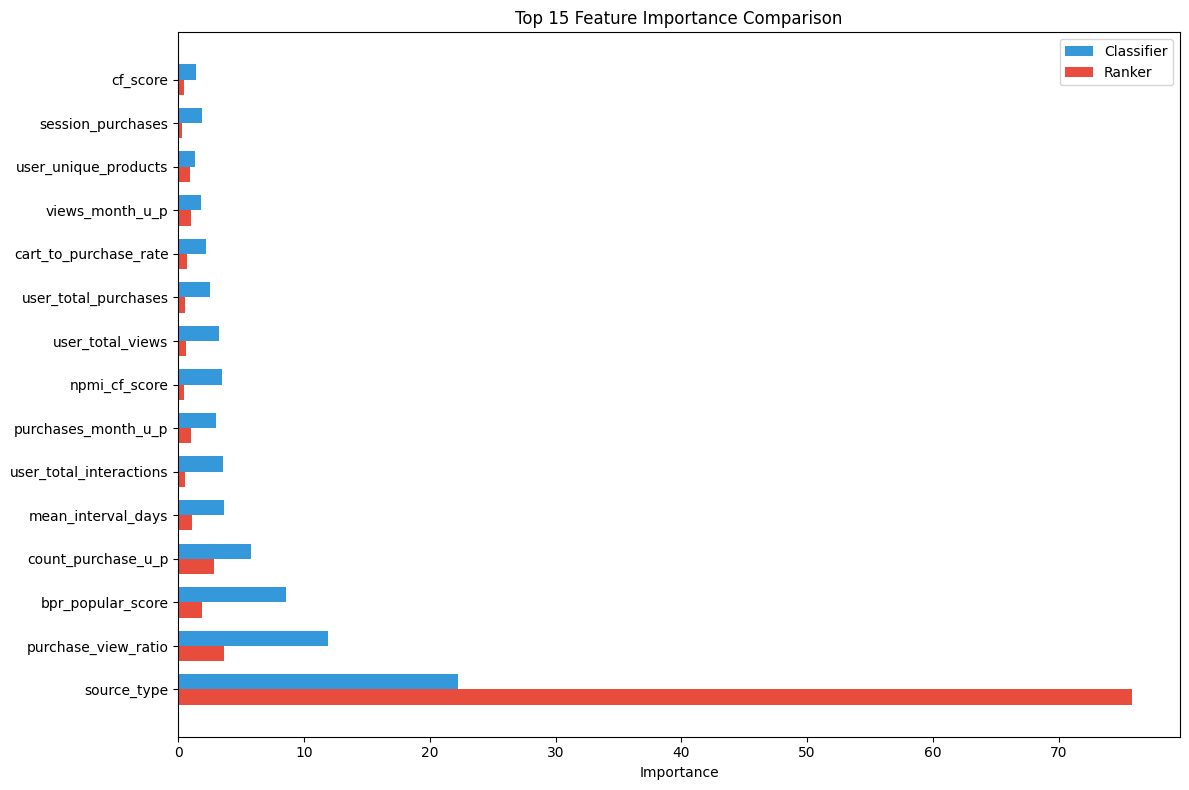

In [9]:
# Compare feature importance between models
if 'feature_importance' in classifier_results and 'feature_importance' in ranker_results:
    # Get all features from both models
    all_features = set(list(classifier_results['feature_importance'].keys()) + 
                        list(ranker_results['feature_importance'].keys()))
    
    # Create comparison dataframe
    fi_comparison = {'Feature': []}
    fi_comparison['Classifier Importance'] = []
    fi_comparison['Ranker Importance'] = []
    
    for feature in all_features:
        fi_comparison['Feature'].append(feature)
        fi_comparison['Classifier Importance'].append(
            classifier_results['feature_importance'].get(feature, 0))
        fi_comparison['Ranker Importance'].append(
            ranker_results['feature_importance'].get(feature, 0))
        
    # Convert to DataFrame and sort by average importance
    fi_df = pd.DataFrame(fi_comparison)
    fi_df['Average Importance'] = (fi_df['Classifier Importance'] + fi_df['Ranker Importance']) / 2
    fi_df = fi_df.sort_values('Average Importance', ascending=False).reset_index(drop=True)
    
    # Save to results directory
    # fi_df.to_csv(f"{results_dir}/feature_importance_comparison.csv", index=False)
    
    # Display top features
    print("Top 20 Features by Average Importance:")
    display(fi_df.head(20))
    
    # Plot top 15 features
    plt.figure(figsize=(12, 8))
    top_n = 15
    top_features = fi_df.head(top_n)
    
    x = range(len(top_features))
    width = 0.35
    
    plt.barh([p + width/2 for p in x], top_features['Classifier Importance'], 
            height=width, label='Classifier', color='#3498db')
    plt.barh([p - width/2 for p in x], top_features['Ranker Importance'], 
            height=width, label='Ranker', color='#e74c3c')
    
    plt.yticks(x, top_features['Feature'])
    plt.xlabel('Importance')
    plt.title(f'Top {top_n} Feature Importance Comparison')
    plt.legend()
    plt.tight_layout()
    plt.show()

## CatBoost Ranker with text features

In [ ]:
ranker_experiment = Experiment("catboost_ranker", (Config
    .load('default_config.yaml')
    .set('model.type', 'catboost_ranker')
    .set('model.config.catboost_ranker.iterations', 500)
    .set('target', 'Weighted')
))

# Setup and run
ranker_experiment.setup()
ranker_results = ranker_experiment.run()

# Print metrics
print(f"\nCatBoost Ranker Results:")
for metric, value in ranker_results['metrics'].items():
    print(f"  {metric}: {value:.6f}")

2025-05-18 02:37:08,716 - lavka_recsys.Experiment(catboost_ranker_48aab0) - INFO - Initialized experiment: catboost_ranker_48aab0
2025-05-18 02:37:08,724 - lavka_recsys.Experiment(catboost_ranker_48aab0) - INFO - Config saved: results/catboost_ranker_48aab0_config.json
2025-05-18 02:37:08,725 - lavka_recsys.Experiment(catboost_ranker_48aab0) - INFO - Setting up experiment environment...
2025-05-18 02:37:08,727 - lavka_recsys.DataLoader - INFO - Loading training data from ../../data/lavka/train.parquet


2025-05-18 02:37:08,955 - lavka_recsys.DataLoader - INFO - Loading test data from ../../data/lavka/test.parquet
2025-05-18 02:37:09,212 - lavka_recsys.DataLoader - INFO - Holdout Split:
2025-05-18 02:37:09,236 - lavka_recsys.DataLoader - INFO -   train:	2022-12-31 18:46:42 → 2024-01-03 17:31:52 (15_070_276 rows, 367 days)
2025-05-18 02:37:09,239 - lavka_recsys.DataLoader - INFO -   holdout:	2024-01-03 17:56:48 → 2024-02-02 17:34:51 (1_438_338 rows, 29 days)
2025-05-18 02:37:09,240 - lavka_recsys.Experiment(catboost_ranker_48aab0) - INFO - Setup complete.
2025-05-18 02:37:09,241 - lavka_recsys.Experiment(catboost_ranker_48aab0) - INFO - Starting experiment run...
2025-05-18 02:37:09,512 - lavka_recsys.DataLoader - INFO - Validation Split:
2025-05-18 02:37:09,533 - lavka_recsys.DataLoader - INFO -   train_history:	2022-12-31 18:46:42 → 2023-11-04 17:16:23 (12_082_523 rows, 307 days)
2025-05-18 02:37:09,536 - lavka_recsys.DataLoader - INFO -   train_target:	2023-11-04 18:19:12 → 2023-12-0

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because PFound, PrecisionAt, RecallAt, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PrecisionAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric RecallAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


2025-05-18 02:38:34,026 - lavka_recsys.Experiment(catboost_ranker_48aab0) - INFO - Training completed in 81.31s
2025-05-18 02:38:34,037 - lavka_recsys.Experiment(catboost_ranker_48aab0) - INFO - Evaluating on holdout.
2025-05-18 02:38:35,730 - lavka_recsys.CachedFeatureFactory - INFO - Using cached feature batch
2025-05-18 02:38:35,949 - lavka_recsys.CatBoostRankerModel - INFO - Sorting data by group_id for grouped ranking
2025-05-18 02:38:37,811 - lavka_recsys.CatBoostRankerModel - INFO - Converting 'is_weekend' to string for CatBoost
2025-05-18 02:38:38,064 - lavka_recsys.CatBoostRankerModel - INFO - Converting 'user_segment' to string for CatBoost
2025-05-18 02:38:38,081 - lavka_recsys.CatBoostRankerModel - INFO - Converting 'source_type' to string for CatBoost
2025-05-18 02:38:38,100 - lavka_recsys.CatBoostRankerModel - INFO - Converting 'city_name' to string for CatBoost
2025-05-18 02:38:39,636 - lavka_recsys.Experiment(catboost_ranker_48aab0) - WARNING - Binarizing target for met

In [5]:
# Print feature importance
if 'feature_importance' in ranker_results:
    print("\nTop 15 Important Features:")
    top_features = sorted(ranker_results['feature_importance'].items(), 
                        key=lambda x: x[1], reverse=True)[:15]
    for feature, importance in top_features:
        print(f"  {feature}: {importance:.6f}")


Top 15 Important Features:
  source_type: 63.673796
  purchase_view_ratio: 3.013199
  count_purchase_u_p: 2.494187
  bpr_popular_score: 1.848078
  views_month_u_p: 1.069384
  mean_interval_days: 1.008569
  product_embed_1: 0.958753
  product_unique_users: 0.951344
  purchases_month_u_p: 0.899269
  puresvd_cf_score: 0.751625
  cart_to_purchase_rate: 0.727287
  ctr_product: 0.700020
  product_embed_5: 0.647384
  cat_embed_2: 0.626036
  product_embed_13: 0.624197


In [6]:
ranker_experiment.create_submission()

2025-05-18 02:39:23,407 - lavka_recsys.Experiment(catboost_ranker_48aab0) - INFO - Computing predictions...
2025-05-18 02:39:23,414 - lavka_recsys.DataLoader - INFO - Holdout data merged back into training data.
2025-05-18 02:39:23,451 - lavka_recsys.DataLoader - INFO - Validation Split:
2025-05-18 02:39:23,485 - lavka_recsys.DataLoader - INFO -   history:	2022-12-31 18:46:42 → 2024-01-03 17:31:52 (15_070_276 rows, 367 days)
2025-05-18 02:39:23,490 - lavka_recsys.DataLoader - INFO -   target:	2024-01-03 17:56:48 → 2024-02-02 17:34:51 (1_438_338 rows, 29 days)
2025-05-18 02:39:25,278 - lavka_recsys.CachedFeatureFactory - INFO - Using cached feature batch
2025-05-18 02:39:25,280 - lavka_recsys.ModelFactory - INFO - Creating catboost_ranker model with params: {'iterations': 500, 'loss_function': 'YetiRankPairwise', 'eval_metric': 'NDCG:top=10', 'early_stopping_rounds': 50, 'custom_metric': ['NDCG:top=10', 'PrecisionAt:top=10', 'RecallAt:top=10'], 'task_type': 'GPU', 'devices': '4,5', 'thr

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Default metric period is 5 because PFound, PrecisionAt, RecallAt, NDCG is/are not implemented for GPU
Metric PFound is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:top=10;type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric PrecisionAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric RecallAt:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


2025-05-18 02:40:32,791 - lavka_recsys.Experiment(catboost_ranker_48aab0) - INFO - Training completed in 67.51s
2025-05-18 02:40:32,797 - lavka_recsys.DataLoader - INFO - Holdout data merged back into training data.
2025-05-18 02:40:32,830 - lavka_recsys.CachedFeatureFactory - INFO - Generating feature batch
2025-05-18 02:40:32,832 - lavka_recsys.FeatureFactory - INFO - Invoking feature generators: source_type, count_purchase_user_product, count_purchase_user_store, ctr_product, cart_to_purchase_rate, purchase_view_ratio, recency_user_product, user_stats, product_stats, store_stats, city_stats, product_temporal_patterns, recency_user_store, time_features_cycl, time_window_user_product, session_features, frequency_features, product_popularity_trend, cross_features, user_segments, memory-based-cf, npmi-cf, puresvd-cf, svd-cf, bpr-popular, product_embeddings, category_embeddings


  0%|          | 0/100 [00:00<?, ?it/s]

BPR processing:   0%|          | 0/807 [00:00<?, ?it/s]

2025-05-18 02:41:43,115 - lavka_recsys.lavka_recsys.feature_generators.text_processor - INFO - Using cached embeddings for product_id with key product_id_sentence-transformers_ai-forever/sbert_large_nlu_ru_20
2025-05-18 02:41:43,163 - lavka_recsys.lavka_recsys.feature_generators.text_processor - INFO - Using cached embeddings for product_category with key product_category_sentence-transformers_ai-forever/sbert_large_nlu_ru_20
2025-05-18 02:41:43,192 - lavka_recsys.FeatureFactory - INFO - Joined features
2025-05-18 02:41:43,194 - lavka_recsys.FeatureFactory - INFO - All column names: {'cat_embed_7', 'cat_embed_14', 'views_day_u_p', 'cat_embed_9', 'hour_relevance', 'cat_embed_2', 'product_total_interactions', 'user_total_purchases', 'purchase_view_ratio', 'user_store_purchase_cross', 'purchases_month_u_p', 'is_weekend', 'user_segment', 'product_embed_12', 'city_total_interactions', 'product_embed_13', 'session_unique_stores', 'cat_embed_11', 'interactions_month_u_p', 'cat_embed_15', 'int

index,request_id
u32,u64
78192,12250825857664677616
292255,12250825857664677616
41187,9106065009157563665
99380,9106065009157563665
59657,10513647694369403596
…,…
186955,9046562081934742702
25513,4964702156890821980
73966,4964702156890821980


Kaggle Public Score `NDCG@10 = 0.41131`.

## CatBoost Ranker with hparam optimization

In [ ]:
import optuna
import wandb

wandb.login()

In [ ]:
def objective(trial: optuna.Trial):
    run_name = f"optuna_trial_{trial.number}"

    params_to_tune = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 4, 10),
        'iterations': trial.suggest_int("iterations", 200, 1000),
        'random_strength': trial.suggest_float('random_strength', 1e-8, 1.0, log=True),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'loss_function': trial.suggest_categorical('loss_function', [
            'YetiRankPairwise', 'PairLogitPairwise', 
        ])
    }

    # Create a new config for this trial
    config = (Config.load('default_config.yaml')
        .set('model.type', 'catboost_ranker')
        .set('target', 'Weighted')
        .set('model.config.catboost_ranker.loss_function', 'YetiRankPairwise')
        .set('model.config.catboost_ranker.eval_metric', 'NDCG:top=10')
        .set('model.config.catboost_ranker.task_type', 'GPU')
        .set('model.config.catboost_ranker.devices', '4,5')
        .set('model.config.catboost_ranker.early_stopping_rounds', 50)
        .set('model.config.catboost_ranker.random_strength', 50)
        .set('model.config.catboost_ranker.verbose', 0) # Keep Optuna trials quiet
        .set('feature_generators', [
            "source_type",
            "count_purchase_user_product",
            "count_purchase_user_store",
            "ctr_product",
            "cart_to_purchase_rate",
            "purchase_view_ratio",       
            "recency_user_product",
            "user_stats",
            "product_stats",
            "store_stats",
            "city_stats",
            "product_temporal_patterns",
            "recency_user_store",
            "time_features_cycl",
            "time_window_user_product",
            "session_features",
            "frequency_features",
            "product_popularity_trend",
            "cross_features",
            "user_segments",
            "memory-based-cf",       # Collaborative filtering
            "npmi-cf",               # Collaborative filtering
            "puresvd-cf",            # Collaborative filtering
            "svd-cf" ,               # Collaborative filtering
            "bpr-popular",           # Implicit item2item
            "product_embeddings",    # NLP feature
            "category_embeddings",   # NLP feature
            # - "user_product_similarity" # Weighted similarity between user history and product
            "text_similarity_cluster", # Product clusters based on text similarity
            "text_diversity_features", # How different a product is from user's history
        ])
    )
        
    # Update config with Optuna's suggested params
    for p_name, p_value in params_to_tune.items():
        config = config.set(f'model.config.catboost_ranker.{p_name}', p_value)

    # Create and run a new experiment
    exp_name = f"optuna_trial_{trial.number}_{int(time.time())}"
    with wandb.init(
        project="rs25_catboost_ranker_optuna",
        name=run_name,
        config=params_to_tune,
        reinit=True,
        save_code=True
    ):
        trial_experiment = Experiment(exp_name, config)
        trial_experiment.setup()
        results = trial_experiment.run()

        ndcg_score = results['metrics']['ndcg@10']
        wandb.log(results['metrics'])
        if 'feature_importance' in results and results['feature_importance']:
            fi_to_log = {f"fi_{feat.replace('.', '_')}": val for feat, val in results['feature_importance'].items()}
            wandb.log(fi_to_log)

    return ndcg_score

In [ ]:
import joblib

study = optuna.create_study(direction='maximize') 
study.optimize(objective, n_trials=50)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial

print("  Value (NDCG@10): ", best_trial.value)
print("  Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

best_params_optuna = best_trial.params
joblib.dump(study, 'catboost_ranker_hparam_study.joblib')